In [211]:
#tensorflow 버전 확인
import tensorflow as tf
print(tf.__version__)

2.6.0


In [212]:
# device list에 GPU있나 확인
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17278476189571699537
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7799308288
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16795248642453607097
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [213]:
#라이브러리 설치
!pip install transformers
!pip install keras==2.6

!pip install scikit-learn

#필요한 모듈 불러오기


GPU available: True


In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

from tabulate import tabulate
from tqdm import trange
import random
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


print("GPU available:",torch.cuda.is_available())

GPU available: True


In [13]:
def printNpRatio(df):
    neg = len(df[df['polarity'] == 0])
    pos=len(df[df['polarity'] == 1])
    print("positive: {}, negative: {}".format(pos,neg))
    print("positive {:.4f}, negative {:.4f}".format(pos/(pos+neg),neg/(pos+neg)))

In [14]:
def printLenStat(df,colName):
    lendf = pd.DataFrame()
    lendf['length'] = df[colName].apply(len)
    print(lendf.length.describe())

In [15]:
# 내 깃허브 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
# Food 속성 리뷰
url='https://raw.githubusercontent.com/Eunjin3395/graduation_project/main/data/food_total.csv'
df = pd.read_csv(url,sep=',', header=0, encoding_errors='ignore')
df.head(5)

,id,text,category,polarity
0,2777,"To be completely fair, the only redeeming fact...",food,1
1,1634,"The food is uniformly exceptional, with a very...",food,1
2,2846,"Not only was the food outstanding, but the lit...",food,1
3,1571,It is very overpriced and not very tasty.,food,0
4,1458,Our agreed favorite is the orrechiete with sau...,food,1


In [16]:
printNpRatio(df)

positive: 1107, negative: 308
positive 0.7823, negative 0.2177


In [17]:
printLenStat(df,'text')

count    1415.000000
mean       79.168198
std        46.640079
min         6.000000
25%        47.500000
50%        70.000000
75%       102.000000
max       370.000000
Name: length, dtype: float64


In [18]:
text = df.text.values
labels = df.polarity.values

In [19]:
# 전처리
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [20]:
MAX_LENGTH=150
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer,max_len_input=MAX_LENGTH):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = max_len_input,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                        truncation=True
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)

  # token_id 리스트 추출
  token_id.append(encoding_dict['input_ids']) 
  # attention_mask 리스트 추출
  attention_masks.append(encoding_dict['attention_mask'])


# 리스트를 텐서로
token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

In [21]:
VAL_RATIO= 0.2
batch_size = 8

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = VAL_RATIO,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )


print("train: {}".format(len(train_idx)))
print("validation: {}".format(len(val_idx)))


train: 1132
validation: 283


In [22]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)

  b_accuracy = (tp + tn) / len(labels)
  return b_accuracy

In [23]:
# BERT 모델 불러오기
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = True,
    output_hidden_states = False,
)


optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5, # learning rate 설정
                              eps = 1e-08
                              )

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [24]:
# GPU로 학습하도록 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 학습 횟수 설정
epochs = 15

idx=0
epo_list=[]
train_loss_list=[]
val_accuracy_list=[]

for _ in trange(epochs, desc = 'Epoch'):
    idx+=1
    epo_list.append(idx)

    # ========== Training ==========
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========
    model.eval()

    # Tracking variables 
    val_accuracy = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
    

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    val_accuracy_temp=sum(val_accuracy)/len(val_accuracy)
    train_loss_list.append(round(tr_loss / nb_tr_steps,4))
    val_accuracy_list.append(round(val_accuracy_temp,4))


Epoch:   7%|███████▏                                                                                                    | 1/15 [00:11<02:44, 11.76s/it]


	 - Train loss: 0.3241
	 - Validation Accuracy: 0.8819


Epoch:  13%|██████████████▍                                                                                             | 2/15 [00:22<02:22, 10.95s/it]


	 - Train loss: 0.1322
	 - Validation Accuracy: 0.9097


Epoch:  20%|█████████████████████▌                                                                                      | 3/15 [00:32<02:08, 10.71s/it]


	 - Train loss: 0.0670
	 - Validation Accuracy: 0.8958


Epoch:  27%|████████████████████████████▊                                                                               | 4/15 [00:43<01:56, 10.61s/it]


	 - Train loss: 0.0964
	 - Validation Accuracy: 0.8819


Epoch:  33%|████████████████████████████████████                                                                        | 5/15 [00:53<01:45, 10.57s/it]


	 - Train loss: 0.0383
	 - Validation Accuracy: 0.9236


Epoch:  40%|███████████████████████████████████████████▏                                                                | 6/15 [01:04<01:35, 10.57s/it]


	 - Train loss: 0.0133
	 - Validation Accuracy: 0.9062


Epoch:  47%|██████████████████████████████████████████████████▍                                                         | 7/15 [01:14<01:24, 10.54s/it]


	 - Train loss: 0.0013
	 - Validation Accuracy: 0.9132


Epoch:  53%|█████████████████████████████████████████████████████████▌                                                  | 8/15 [01:25<01:13, 10.53s/it]


	 - Train loss: 0.0302
	 - Validation Accuracy: 0.8924


Epoch:  60%|████████████████████████████████████████████████████████████████▊                                           | 9/15 [01:35<01:03, 10.52s/it]


	 - Train loss: 0.0289
	 - Validation Accuracy: 0.9028


Epoch:  67%|███████████████████████████████████████████████████████████████████████▎                                   | 10/15 [01:46<00:52, 10.53s/it]


	 - Train loss: 0.0176
	 - Validation Accuracy: 0.9132


Epoch:  73%|██████████████████████████████████████████████████████████████████████████████▍                            | 11/15 [01:56<00:42, 10.55s/it]


	 - Train loss: 0.0155
	 - Validation Accuracy: 0.8854


Epoch:  80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 12/15 [02:07<00:31, 10.58s/it]


	 - Train loss: 0.0401
	 - Validation Accuracy: 0.8993


Epoch:  87%|████████████████████████████████████████████████████████████████████████████████████████████▋              | 13/15 [02:18<00:21, 10.60s/it]


	 - Train loss: 0.0216
	 - Validation Accuracy: 0.8993


Epoch:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 14/15 [02:28<00:10, 10.61s/it]


	 - Train loss: 0.0178
	 - Validation Accuracy: 0.9097


Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [02:39<00:00, 10.62s/it]


	 - Train loss: 0.0022
	 - Validation Accuracy: 0.9005


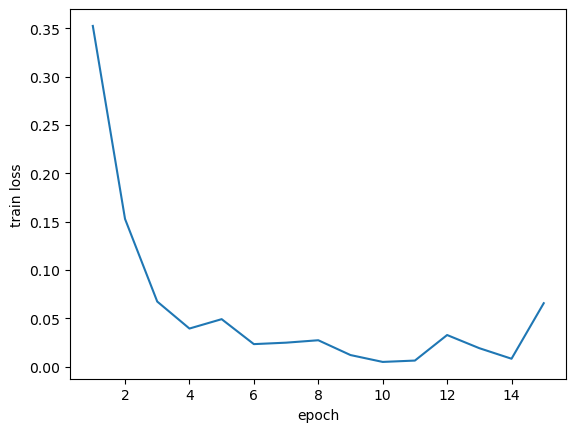

In [20]:
# train loss 그래프
plt.plot(epo_list, train_loss_list)
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.show()

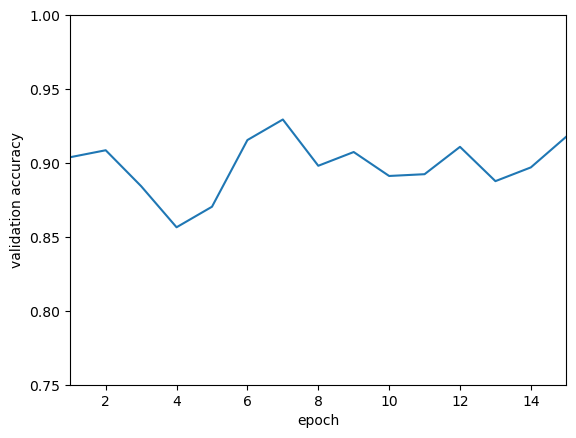

In [21]:
plt.plot(epo_list, val_accuracy_list)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.axis([1,epochs , 0.75, 1])
plt.show()

In [25]:
#새로운 리뷰를 분류해보자

def test_sentence(sentence):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []

    # 전처리
    encoding = preprocessing(sentence, tokenizer)
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

    prediction = 'Positive' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    return prediction
    

    
    
new_sentence ='The food was bad, but it was cheap'
# 'It''s good, but the owner is so unkind. Some of the plates didn''t clean properly because there was something on them. But it''s cost-effective.'





print('입력 문장:', new_sentence)
print('분류:', test_sentence(new_sentence))

입력 문장: The food was bad, but it was cheap
분류: Negative


In [28]:
from bertviz import model_view
def viewBertviz(sent,length):
    encoding = preprocessing(sent, tokenizer,length)
    test_ids = []
    test_attention_mask = []
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        model_output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))
        
    prediction = 'Positive' if np.argmax(model_output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    attention=model_output[-1]
    tokens=tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
    
    model_view(attention, tokens)

In [29]:
viewBertviz("Food was delicious, but it was expensive.",11)

<IPython.core.display.Javascript object>

In [30]:
def testAccuracy(text,labels):
    count=0
    wrongResult=[] # [[String text,Boolean prediction ], ... ]
    rightResult=[] # [[String text,Boolean prediction ], ... ]

    for i in range(len(labels)):
        t = text[i]
        color_s='\033[31m' 
        color_e='\033[0m'
    
        prediction=test_sentence(t)
        if(prediction=="Negative"):
            result=0
        else:
            result=1
        
        if(result==labels[i]):
            count+=1     
            color_s=''
            color_e=''
            rightResult.append([t,1 if prediction=="Positive" else 0])
        else:
            wrongResult.append([t,1 if prediction=="Positive" else 0])
        print(color_s+"=============================== Input {} ===============================".format(i+1))
        print(t)
        print("model result:",prediction,"\nanswer:", labels[i],color_e)
        print("")


    print("test accuracy: {:.4f}".format(count/len(labels)))
    return rightResult,wrongResult

In [31]:
# 개별 문장의 attention 추출하는 함수
def get_attention(encoding):
    # 토큰 ID와 attention mask를 위한 리스트
    test_ids = []
    test_attention_mask = []
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim = 0)
    test_attention_mask = torch.cat(test_attention_mask, dim = 0)
    
    
    # Forward pass, calculate logit predictions
    with torch.no_grad():
        model_output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))
        
    prediction = 'Positive' if np.argmax(model_output.logits.cpu().numpy()).flatten().item() == 1 else 'Negative'
    attention=model_output[-1]
    last_attention=attention[-1]
    tokens=tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])
    
    return attention,last_attention,tokens,prediction

In [32]:
def get_val_len(ids):
    count=0
    for elem in ids:
        if(elem!=0):
            count+=1
    return count

In [33]:
def sort_by_att(attention,tokens):
    '''
        last layer의 attention tensor를 입력 받아 각 token의 attention 값을 head에 대한 평균을 낸 뒤, attention이 높은 token 순으로 idx를 반환하는 함수
    '''
    
    attention=attention[0] # shape: 12,len,len
    
    size=len(tokens)
    
    total_atts_sum=[] # 각 head에 대한 각 토큰의 attention값의 합
    for head in range(0,12):
        att_of_head=attention[head] # 한 head의 attention
        atts_sum_of_head=[0.0]*size # 해당 head 하나의 attention의 합
        for row in att_of_head:
            col=0
            for elem in row:
                value=elem.item()
                atts_sum_of_head[col]+=value # head 하나에 대한 토큰이 가지는 attention 값
                col+=1
        total_atts_sum.append(atts_sum_of_head)
    
    total_sum_value=[0.0]*size
    for elem in total_atts_sum:
        for i in range(0,size):
            total_sum_value[i]+=elem[i]
            

    total_mean=[]
    for elem in total_sum_value:
        total_mean.append(elem/12)
    
    


    idxs=sorted(range(len(total_mean)), key=lambda k: total_mean[k], reverse=True)
    return(idxs)
    

In [34]:
# attention 순서대로 텍스트 배경색 주기
color_code=[
    "\033[48;5;243m",
    "\033[48;5;245m",
    "\033[48;5;247m",
    "\033[48;5;249m",
    "\033[48;5;251m",
    "\033[48;5;253m",
    "\033[48;5;255m"
]
def emp_by_att(attIdxs,tokens):   
    valTokens=[]
    for tok in tokens:
        if(tok!='[CLS]' and tok!='[PAD]' and tok!='[SEP]'):
            valTokens.append(tok)
        
    valIdxs=[]
    for idx in attIdxs:
        if len(valIdxs)==7:
            break;
        
        if(idx>0 and idx<=len(valTokens)):
            if(valTokens[idx-1]!=',' and valTokens[idx-1]!='.'):
                valIdxs.append(idx-1)
    
    resultSent=""
    for i in range(len(valTokens)):
        if(i in valIdxs):
            outTok=color_code[valIdxs.index(i)]+valTokens[i]+"\033[0m"
        else:
            outTok=valTokens[i]
        resultSent+=outTok
        resultSent+=' '
    
    print("========================= emphasize by attention result==========================")
    print(resultSent)

In [35]:
def get_highest_att_tok(idxs,retTok,num):
    count=0
    print("highest attention: ",end="")
    for i in idxs:
        if(i<len(retTok)):
            if(retTok[i]!='[CLS]' and retTok[i]!='[SEP]' and retTok[i]!='.' and retTok[i]!=','):
                if(count<num):
                    print(retTok[i],end=" ")
                    count+=1
                

In [36]:
def empSentByAtt(sent,length,high):
    encoding = preprocessing(sent, tokenizer,length)
    
    MAX_LEN_IN=get_val_len(encoding['input_ids'][0])
    print('MAX_LEN: ',MAX_LEN_IN)
    
    retAtt,retLastAtt,retTok,prediction=get_attention(encoding)
    idxs=sort_by_att(retLastAtt,retTok)
    emp_by_att(idxs,retTok)
    get_highest_att_tok(idxs,retTok,high)

In [37]:
#test data 세팅

# 내 깃허브 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='https://raw.githubusercontent.com/Eunjin3395/graduation_project/main/data/food_test.csv'
test_df = pd.read_csv(test_url,sep=',', header=0, encoding_errors='ignore')
test_df.head(5)

,id,text,category,polarity
0,3440,"Even though its good seafood, the prices are t...",aa,1
1,en_CatalRestaurant__UvaBar_477861889:4,My g/f and I both agreed the food was very med...,food,0
2,1242,But the coconut rice was good.,food,1
3,en_BlueRibbonSushi_478218345:2,It has great sushi and even better service.,food,1
4,882,"While the ambiance and atmosphere were great, ...",food,0


In [38]:
printNpRatio(test_df)
print()
printLenStat(test_df,'text')

positive: 46, negative: 34
positive 0.5750, negative 0.4250

count     80.000000
mean      68.025000
std       41.399864
min        4.000000
25%       37.000000
50%       62.500000
75%       85.750000
max      193.000000
Name: length, dtype: float64


In [39]:
test_text = test_df.text.values
test_labels = test_df.polarity.values

rightResult,wrongResult=testAccuracy(test_text,test_labels)
    

=============================== Input 1 ===============================
Even though its good seafood, the prices are too high.
model result: Positive 
answer: 1 

=============================== Input 2 ===============================
My g/f and I both agreed the food was very mediocre especially considering the price.
model result: Negative 
answer: 0 

=============================== Input 3 ===============================
But the coconut rice was good.
model result: Positive 
answer: 1 

=============================== Input 4 ===============================
It has great sushi and even better service.
model result: Positive 
answer: 1 

=============================== Input 5 ===============================
While the ambiance and atmosphere were great, the food and service could have been a lot better.
model result: Negative 
answer: 0 

=============================== Input 6 ===============================
The food was lousy -too sweet or too salty and the portions tiny.
model res

=============================== Input 53 ===============================
My goodness, everything from the fish to the rice to the seaweed was absolutely amazing.
model result: Positive 
answer: 1 

=============================== Input 54 ===============================
Consistently good Japanese Tapas.
model result: Positive 
answer: 1 

=============================== Input 55 ===============================
Anyway, the food is good, the price is right and they have a decent wine list.
model result: Positive 
answer: 1 

=============================== Input 56 ===============================
The bagels are fabulous.
model result: Positive 
answer: 1 

=============================== Input 57 ===============================
All the appetizers and salads were fabulous, the steak was mouth watering and the pasta was delicious!!!
model result: Positive 
answer: 1 

=============================== Input 58 ===============================
I love the fact that the pizza tastes so good and 

In [193]:
#잘못 분류된 문장의 attention
for elem in wrongResult: # [[String text,Boolean prediction ], ... ]
    print('입력 문장:', elem[0]) 
    print('분류:', elem[1])

    empSentByAtt(elem[0],50,5)

    print()
    print()
    print()
    print()

입력 문장: I liked the atmosphere very much but the food was not worth the price.
분류: 1
MAX_LEN:  21
========================= emphasize by attention result==========================
it ' s good . but it ' s small and they didn ' t give me a fork 
highest attention: t ' small they but 



입력 문장: I know many people have their favorite types of pizza and pizza places, but Mioposto's pizza lacks quality and good taste.
분류: 1
MAX_LEN:  21
========================= emphasize by attention result==========================
it ' s good . but it ' s small and they didn ' t give me a fork 
highest attention: t ' small they but 



입력 문장: Maybe it is good for that one night once in a blue moon when the chefs decide to use fish that's half-way decent.
분류: 1
MAX_LEN:  21
========================= emphasize by attention result==========================
it ' s good . but it ' s small and they didn ' t give me a fork 
highest attention: t ' small they but 



입력 문장: They are not greasy or anything.
분류: 0
M

In [91]:
#NAVER test data 세팅

# data/naver_data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/naver_data/naver_food_test.csv'
n_test_df = pd.read_csv(test_url,sep=',', header=0,encoding="CP949")
n_test_df.head(5)

,Unnamed: 0,id,category,text,polarity,trans_text
0,0,180,food,"쟁반짜장은 너무 짜고, 면이 불어 있었어요\n탕수육은 비린내가 심하고, 짬뽕은 양파...",0,The jajangmyeon on the tray was too salty and ...
1,1,580,food,매장이 엄청 지저분합니다.\n사이다는 단맛이 하나도 없는 탄산수였습니다.\n직원이 ...,0,The store is really messy.. Sprite was carbona...
2,2,605,food,고기 기름이 넘 많네요\n서비스도 조금 부족한듯\n다소 아쉽네요,0,There's too much meat oil. The service seems t...
3,3,1696,food,토마호크 비추천.\n고기가 질김,0,I don't recommend Tomahawk.. the toughness of ...
4,4,2550,food,스테이크덮밥이랑 큐브스테이크덮밥을 먹엇는데 개인적으로 다음식 안좋아하는 분은 큐브스...,0,I ate rice with steak and rice with cube steak...


In [145]:
printNpRatio(n_test_df)
print()
printLenStat(n_test_df,'trans_text')

positive: 59, negative: 21
positive 0.7375, negative 0.2625

count     80.000000
mean     120.200000
std       51.804745
min       30.000000
25%       69.750000
50%      119.500000
75%      163.250000
max      226.000000
Name: length, dtype: float64


In [185]:
# naver test data에 대한 분류 및 accuracy 측정

n_test_text = n_test_df.trans_text.values
n_test_labels = n_test_df.polarity.values


NaverRightResult,NaverWrongResult=testAccuracy(n_test_text,n_test_labels)

=============================== Input 1 ===============================
The jajangmyeon on the tray was too salty and the noodles were swollen. Tangsuyuk had a bad fishy smell, jjamppong had a lot of onions, and squid had only 3 pieces
model result: Negative 
answer: 0 

=============================== Input 2 ===============================
The store is really messy.. Sprite was carbonated water without any sweetness.. There seemed to be a shortage of staff.
model result: Negative 
answer: 0 

=============================== Input 3 ===============================
There's too much meat oil. The service seems to be a little lacking. It's a bit disappointing
model result: Negative 
answer: 0 

=============================== Input 4 ===============================
I don't recommend Tomahawk.. the toughness of the meat
model result: Negative 
answer: 0 

=============================== Input 5 ===============================
I ate rice with steak and rice with cube steak, but personally,

=============================== Input 40 ===============================
The taste is soft and very delicious.. They were very kind and gave us a service. I strongly recommend it.
model result: Positive 
answer: 1 

=============================== Input 41 ===============================
It's a sandwich I often eat for a meal and it's always delicious and filling :) The vegetables are fresh and the bread is delicious. The staff is also kind, so I use it often
model result: Positive 
answer: 1 

=============================== Input 42 ===============================
The bread is chewy. It's delicious. It hasn't been long since it opened, so the baker's. I think it's more passionate.. . Warm bread made by warm people. Try it~~^^
model result: Positive 
answer: 1 

=============================== Input 43 ===============================
The quality of the meat and the tempura are very fresh and delicious.. I can't help but write a review... Thank you!
model result: Positive 
answer: 1 



In [181]:
#잘못 분류된 문장의 attention
for elem in NaverWrongResult:
    print('입력 문장:', elem[0])
    print('분류:', elem[1])

    empSentByAtt(elem[0],70,5)

    print()
    print()
    print()
    print()

입력 문장: I've never been to such an insincere and unfriendly restaurant. I read the review and came here saying that it's delicious even if it's unfriendly, but it's not delicious;;
분류: Positive
MAX_LEN:  21
========================= emphasize by attention result==========================
it ' s good . but it ' s small and they didn ' t give me a fork 
highest attention: t small ' they and 





In [151]:
#잘 분류된 문장의 attention
count=0
for elem in NaverRightResult:
    count+=1
    print(count)
    print('입력 문장:', elem[0])
    print('분류:', elem[1])

    empSentByAtt(elem[0],70,5)

    print()
    print()
    print()
    print()

1
입력 문장: The jajangmyeon on the tray was too salty and the noodles were swollen. Tangsuyuk had a bad fishy smell, jjamppong had a lot of onions, and squid had only 3 pieces
분류: Positive
MAX_LEN:  47
========================= emphasize by attention result==========================
the ja ##jan ##gm ##ye ##on on the tray was too salty and the noodles were swollen . tang ##su ##yu ##k had a bad fish ##y smell , jj ##amp ##pon ##g had a lot of onions , and squid had only 3 pieces 
highest attention: the bad too and had 



2
입력 문장: The store is really messy.. Sprite was carbonated water without any sweetness.. There seemed to be a shortage of staff.
분류: Positive
MAX_LEN:  29
========================= emphasize by attention result==========================
the store is really messy . . sp ##rite was carbonate ##d water without any sweetness . . there seemed to be a shortage of staff . 
highest attention: to seemed messy carbonate really 



3
입력 문장: There's too much meat oil. The service se

========================= emphasize by attention result==========================
far from green onion kim ##chi , cabbage kim ##chi has fallen . . . it ' s greasy to my taste . . . i have no intention of rev ##isi ##ting . 
highest attention: ' my taste ##chi greasy 



18
입력 문장: Not until long ago. The owner changed and the taste changed
분류: Positive
MAX_LEN:  14
========================= emphasize by attention result==========================
not until long ago . the owner changed and the taste changed 
highest attention: and changed not changed the 



19
입력 문장: as if it's not seasoned enough
분류: Positive
MAX_LEN:  10
========================= emphasize by attention result==========================
as if it ' s not seasoned enough 
highest attention: as if it enough s 



20
입력 문장: The food is a bit salty. Rice and curry are refilled
분류: Positive
MAX_LEN:  16
========================= emphasize by attention result==========================
the food is a bit salty . rice and curry a

========================= emphasize by attention result==========================
it ' s so good here . . . but it ' s hard to wait , so i ' m going to wrap it up now . . i ' d like you to change it to a waiting machine ! it ' s so uncomfortable to have to wait in front of the store ##cr ##ying 
highest attention: uncomfortable ' ' i i 



34
입력 문장: Even though it was a weekday evening, the atmosphere was amazing.. But Sundaeguk was so delicious that I could endure and wait. I want to eat it with soju next time! I did it again today!
분류: Positive
MAX_LEN:  48
========================= emphasize by attention result==========================
even though it was a weekday evening , the atmosphere was amazing . . but sun ##dae ##gu ##k was so delicious that i could endure and wait . i want to eat it with so ##ju next time ! i did it again today ! 
highest attention: wait to could evening ##k 



35
입력 문장: I've been waiting for 40 minutes for lunch on Saturday It wasn't enough But it's not g

========================= emphasize by attention result==========================
they are kind and the drinks are delicious . it would be better if the store was a little bigger 
highest attention: better would bigger if it 



48
입력 문장: The meat is so goodIt's my first time in Pyeongtaek, and thanks to you, I have a good memory. They grill meat themselves, and they're all so nice and kind
분류: Positive
MAX_LEN:  45
========================= emphasize by attention result==========================
the meat is so good ##it ' s my first time in p ##ye ##ong ##ta ##ek , and thanks to you , i have a good memory . they grill meat themselves , and they ' re all so nice and kind 
highest attention: ' ' kind ##it so 



49
입력 문장: The pork belly was really good, but the pork neck was crazy!!! I'm amazed as soon as I eat it Do you really recommend it!!!! It's so nice that the staff cooked it deliciously. I'll save it as a good restaurant
분류: Positive
MAX_LEN:  59
========================= emphasi

========================= emphasize by attention result==========================
it ' s as delicious as it ' s rumored . i think it ' s a bit expensive 
highest attention: expensive think a bit ' 



64
입력 문장: The food is really good. I knew why it was so famous. Mackerel sushi is really good, but there are no pictures!It's so good
분류: Positive
MAX_LEN:  36
========================= emphasize by attention result==========================
the food is really good . i knew why it was so famous . mack ##ere ##l su ##shi is really good , but there are no pictures ! it ' s so good 
highest attention: no ' but i famous 



65
입력 문장: I really enjoyed the meal! It was the most delicious place I've ever been to. I'll go again later
분류: Positive
MAX_LEN:  27
========================= emphasize by attention result==========================
i really enjoyed the meal ! it was the most delicious place i ' ve ever been to . i ' ll go again later 
highest attention: ' ' later go ! 



66
입력 문장: It's g

In [40]:
#NAVER final test data 세팅

# data/naver_data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/naver_data/naver_fin_food_trans.csv'
nf_df = pd.read_csv(test_url,sep=',', header=0)
nf_df.head(5)

,Unnamed: 0,id,category,text,polarity,trans_text
0,0,0,taste,요즘 평양냉면 제대로 하는집이 많지 않은데 여긴 찐입니다???? 자극적이지 않은데 ...,1,There aren't many restaurants that make Pyeong...
1,1,2,taste,평양냉면 맛도 잘 모르고 갔다가 맛보고 헉~했어요 너무 밍밍했거든요\n건강한 맛인거...,1,I didn't even know the taste of Pyeongyang nae...
2,2,3,taste,"평양냉면이 정말 맛있어요…????평양냉면, 온반 하나씩 시켜서 먹었는데 온반은 삼삼...",1,Pyeongyang naengmyeon is really delicious...I ...
3,3,4,taste,맛있어요~\n근데 오랜만에 갔더니 녹두전 사이즈가 줄어서 놀랐어요 ㅠㅠ,1,It's good. But I was surprised that the size o...
4,4,5,taste,맛있게 먹었습니다\n부담없는 맛과 국물이에요,1,I enjoyed my meal. It's easy to taste and soup


In [41]:
printNpRatio(nf_df)
print()
printLenStat(nf_df,'trans_text')

positive: 145, negative: 11
positive 0.9295, negative 0.0705

count    156.00000
mean      99.00641
std      140.91180
min        9.00000
25%       17.00000
50%       45.00000
75%      110.50000
max      784.00000
Name: length, dtype: float64


In [42]:
# naver final data에 대한 분류 및 accuracy 측정

nf_text = nf_df.trans_text.values
nf_labels = nf_df.polarity.values


NfRightResult,NfWrongResult=testAccuracy(nf_text,nf_labels)

=============================== Input 1 ===============================
There aren't many restaurants that make Pyeongyang naengmyeon properly these days, but this place is real??? It's not stimulating, but it has a deep taste. I'm so full, but I ate it until the end?? It seemed like she was making all the side dishes herself!! The store is spacious and clean, so I think it'll be good for group gatherings!! It's my first time seeing a restaurant with a spacious and clean bathroom like Evaluationok. The hygiene and taste are the best???
model result: Positive 
answer: 1 

=============================== Input 2 ===============================
I didn't even know the taste of Pyeongyang naengmyeon, so I tasted it and gasped It was too bland. I think it's a healthy taste, but it wasn't good for my taste The mung bean pancake was too small and thin for the price
model result: Negative 
answer: 1 

=============================== Input 3 ===============================
Pyeongyang naengmyeon 

=============================== Input 45 ===============================
I like the deep taste
model result: Positive 
answer: 1 

=============================== Input 46 ===============================
Dumpling hot pot and fish cake tray are all good
model result: Positive 
answer: 1 

=============================== Input 47 ===============================
Neat and light tasteA place I want to visit again
model result: Positive 
answer: 1 

=============================== Input 48 ===============================
I like Pyeongyang naengmyeon and go around looking for good restaurants. Unkind first impression! As soon as I was about to understand, I thought restaurants must be unfriendly, but I ordered mulnaengmyeon + Pyeonyuk. A twist here! If it was unkind but not tasty!! It's not to the point where it's not bad, but below the level!! The broth is very seasoned! There's no deep taste!  Until the fishy smell! Every bowl has traces of a lady's thumb slipping into the broth! The price 

=============================== Input 116 ===============================
The restaurant that always eats deliciously
model result: Positive 
answer: 1 

=============================== Input 117 ===============================
Dumpling hot pot, fish cake tray, and cold noodles
model result: Negative 
answer: 1 

=============================== Input 118 ===============================
I went to eat dumpling hot pot and it was really good.. The three of us ordered two servings of hot pot and mung bean pancake, but the amount of hot pot was large, so we ate it full.. I think the meat in dumpling hot pot is good and the soup is clean, so I think I'll go eat it often
model result: Positive 
answer: 1 

=============================== Input 119 ===============================
It's good
model result: Positive 
answer: 1 

=============================== Input 120 ===============================
I like the taste of beef on the taste. It's better than Yeouido evaluation house
model result: Po

In [43]:
def classifyReviews(textarr):
    i=0
    
    posResult=[] # [[String text,Boolean prediction ], ... ]
    negResult=[] # [[String text,Boolean prediction ], ... ]

    neg=0
    pos=0

    for text in textarr:
        prediction=test_sentence(text)
        if(prediction=="Negative"):
            neg+=1
            negResult.append([text,0])
        else:
            pos+=1
            posResult.append([text,1])

        print("=============================== Input {} ===============================".format(i+1))
        print(text)
        print("model result:",prediction)
        print("")
        i+=1


    print("Positive ratio: {:.4f}".format(pos/len(textarr)))
    print("Negative ratio: {:.4f}".format(neg/len(textarr)))
    return posResult, negResult

In [174]:
#naver 음식점 세 곳 data 테스트

# data/naver_data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/naver_data/mongryen_food.csv'
n3_df = pd.read_csv(test_url,sep=',', header=0)
n3_df.head(5)

,id,category,text,trans_text
0,0,taste,특수부위 아주 맛있어요! 보기에는 고기가 두툼해서 질길것 같은데 정말 부드럽고 살살...,Special parts are very delicious! The meat loo...
1,1,taste,두번째 방문이예요 여전히 부드럽고 맛있는고기 만족입니다 :) 치즈듬뿍올린 볶음밥도 ...,This is my second visit I'm still satisfied wi...
2,2,taste,고기 찌개 밥 다 맛있었던 성수 맛집 몽련 !! \n가게도 깔끔하고 넓어서 회식이나...,"Mongryeon, a restaurant in Seongsu that had de..."
3,3,taste,도끼살 진짜 맛있어요!!! 통벌집맥주 달달하니 계속 들어가요ㅜㅠ 특별한날 가기도 좋...,The ax meat is really good!!! It's so sweet th...
4,4,taste,정갈한 반찬과 깨끗한 매장… 고기맛도 좋아요~~!,Neat side dishes and clean stores... I like th...


In [251]:
printLenStat(n3_df,'trans_text')

count    769.000000
mean     142.699610
std      156.812145
min        9.000000
25%       46.000000
50%       96.000000
75%      176.000000
max      964.000000
Name: length, dtype: float64


In [188]:
# naver 3 data에 대한 분류
n3_text=n3_df.trans_text.values
n3_posResult,n3_negResult=classifyReviews(n3_text)

=============================== Input 1 ===============================
Special parts are very delicious! The meat looks thick and tough, but it melts really soft and softly A total twist!! Doenjang jjigae is really good and there's no need for words if you wrap it with seasoned scallions and kimchi! The smoke escapes easily, so you can enjoy the meat without any inconvenience! Good
model result: Positive

=============================== Input 2 ===============================
This is my second visit I'm still satisfied with the soft and delicious meat :) I also enjoyed the fried rice with a lot of cheese!
model result: Positive

=============================== Input 3 ===============================
Mongryeon, a restaurant in Seongsu that had delicious meat stew and rice! The restaurant is clean and spacious, so it's good for company dinners and gatherings ??
model result: Positive

=============================== Input 4 ===============================
The ax meat is really good!!! I

=============================== Input 49 ===============================
- I made a reservation for my family's birthday party in advance and visited! I couldn't get a room because there were 3 people, and I ate at the table on the 2nd floor, but there weren't many seats, so it was good because it wasn't noisy.. - We ordered Mongryeon axe + pork belly + tofu pork belly + herring roe fried rice, and the overall review is that pork belly and pork neck are more delicious than Mongryeon axe. I ate ax meat first and ordered pork belly meat later, but I regretted ordering this from the beginningExcept that the ax meat is unique, there are some tough parts, and the amount was too small, so it was less than I expected. If you take out the weight of the bone, the amount is too small. And I strongly recommend the herring roe fried rice! I can't explain what it tastes like, but it was my first time eating it, and 6,000 won was a bit expensive for fried rice, but it was very luxurious. Beef briske

=============================== Input 116 ===============================
The food is delicious, but the kindness is insufficient, and the service is poor.. For example, when I asked for some tzuran, they said they would give me lamb only if I ordered it. I understand if Tzuran is expensive, but I don't know if it's a lack of understanding of the service... And, it's too loud to be a quiet place to eat
model result: Positive

=============================== Input 117 ===============================
The meat tasted good, but it was too hot on the second floor…
model result: Positive

=============================== Input 118 ===============================
Honey makgeolli is delicious.
model result: Positive

=============================== Input 119 ===============================
The boss is unkind and I suspect cleanliness. It's just water, but it's the same even if a piece of tissue floats in the water and changes it. The meat tasted good, but it wasn't a pleasant meal
model result:

=============================== Input 181 ===============================
They sell wine and special beer. I think it would be good to visit on a special day.. If you visit, please try it The meat is so soft Haha
model result: Positive

=============================== Input 182 ===============================
Even though I made a reservation with my friends, I waited for about 3 minutes, and it was delicious and friendly because I went there before. I ate meat deliciously and ordered fried rice at the end, but my friend and I asked if I could add more rice. I ordered fried rice because I wanted to eat rice again, but I said it was salty enough to need a spoonful of rice, but I didn't know you would respond like that..It was ridiculous. It's not because I don't have money, but the customers' tastes may be wrong, but the fried rice I ordered is salty and I asked for more rice, but I couldn't get cut off. I looked at other customers with that expression. It was so embarrassing. It felt di

=============================== Input 212 ===============================
Lunch is good, and the meat in the evening is good, too!
model result: Positive

=============================== Input 213 ===============================
It's a place that reminds me of a special day The atmosphere is so good and the taste is good. ^^ I'm satisfied with it again
model result: Positive

=============================== Input 214 ===============================
The ax meat is so good
model result: Positive

=============================== Input 215 ===============================
Jeju pork is so delicious and especially the sauce is excellent.. The staff are kind and it's good not to read the room because it's a group room
model result: Positive

=============================== Input 216 ===============================
The food was good, but the seats were so cold ??????????? It must have been hard for you to pay attention to each one because there were many customers, but please check next time…
m

=============================== Input 277 ===============================
Axe meat is good
model result: Positive

=============================== Input 278 ===============================
The meat tastes good. The side dishes are all delicious. They gave us stew, so we each had a bowl of rice
model result: Positive

=============================== Input 279 ===============================
It was a good restaurant where I introduced my friend. I really ate it deliciously.. You must eat fried rice.. Good, good
model result: Positive

=============================== Input 280 ===============================
I enjoyed the meal in a pleasant environment.. I want to come back with my friends and acquaintances on a special day
model result: Positive

=============================== Input 281 ===============================
This is my second visit.. I made a reservation for 2 weeks on my first visit.. 2FEUNG's single room is very satisfying and the serving is very kind. I felt good.. The impo

=============================== Input 348 ===============================
Thank you for the meat But it's kind of weird because the employees are smoking right in front of me
model result: Negative

=============================== Input 349 ===============================
It's delicious and nice, but if you don't open the coke-free wine, I hope you improve itI open everything else
model result: Positive

=============================== Input 350 ===============================
You can eat delicious pork
model result: Positive

=============================== Input 351 ===============================
All the meat was delicious.  Especially ax meat.  But I'd like the staff to be a little nicer. Even if you don't serve with a smile, it would have been better if you spoke softly.
model result: Positive

=============================== Input 352 ===============================
There weren't many customers at lunch on Sunday. I ate pork belly and pork neck, and I was disappointed that pork b

=============================== Input 383 ===============================
It was nice to have an empty space between the tables. The food is so good and nice ^^
model result: Positive

=============================== Input 384 ===============================
The food is good and it's good for small gatherings.
model result: Positive

=============================== Input 385 ===============================
It's been a while since I wanted to eat meat, but it was so good that I inhaled a lot ^^
model result: Positive

=============================== Input 386 ===============================
I really enjoyed the ax meat ^^ I think it's starting to be burnt, so the scent and flavor are added!! All the staff members are kind, too! Good, good
model result: Positive

=============================== Input 387 ===============================
I was informed that it was a cooler space and moved to the center of the hall. It was a meal with my parents, and it was so nice to be able to eat ax meat

=============================== Input 452 ===============================
I really enjoyed the food. I chose the second floor because there were fewer seats than the first floor, and I was satisfied. The bathroom was clean, so it was nice.
model result: Positive

=============================== Input 453 ===============================
Axsal always tastes good with herring roe fried rice!!!Top
model result: Positive

=============================== Input 454 ===============================
Axe meat. Grilled short ribs. They're all good restaurants. They're kind
model result: Positive

=============================== Input 455 ===============================
The atmosphere is good and the taste is good
model result: Positive

=============================== Input 456 ===============================
I visited this place because I wanted to have a good time with my family because it was Married's Day ^^. First of all, he was kind even though he was busy, and the meat tasted so good. My 4-

=============================== Input 486 ===============================
The meat tastes good and the atmosphere is good
model result: Positive

=============================== Input 487 ===============================
The taste is not bad. It's noisy, busy, and weak..
model result: Negative

=============================== Input 488 ===============================
It was delicious!
model result: Positive

=============================== Input 489 ===============================
It's my second visit, so it's nice. The staff is kind and tastes good. I really enjoyed the meal.
model result: Positive

=============================== Input 490 ===============================
I went with my child, and he was so kind and the food was so delicious!!!^^
model result: Positive

=============================== Input 491 ===============================
The atmosphere was good, the meat was really good, the staff was kind, and everything was good, but it was very hot. I think I'll visit again.
mo

=============================== Input 519 ===============================
I'm always satisfied, as always. From a cost-effective meat restaurant to delicious and high-quality meat!! It's a meat restaurant, but it's a really good advantage that it doesn't smell!!
model result: Positive

=============================== Input 520 ===============================
It's a place where I usually go and eat deliciously, but the service was disappointing compared to usual because there were many customers. I missed my order for fried rice, so I waited a long time, but it was delicious!
model result: Positive

=============================== Input 521 ===============================
The atmosphere is good and it's. There's a separate private space, so it's good to have a meeting. Willing to revisit. I recommend it
model result: Positive

=============================== Input 522 ===============================
I visited this place because my name is Magnolia. It was meaningful. The meat and side d

=============================== Input 586 ===============================
The atmosphere was so good and delicious!!
model result: Positive

=============================== Input 587 ===============================
It was delicious
model result: Positive

=============================== Input 588 ===============================
The meat is good!!!
model result: Positive

=============================== Input 589 ===============================
It's a place where I always eat deliciously. Except for one star, the staff's service is a bit...
model result: Positive

=============================== Input 590 ===============================
It's delicious and everything is good, but it's so hot. The air conditioner is the strongest. It's so hot
model result: Positive

=============================== Input 591 ===============================
It was a room with a large window but no view. The meat was delicious. The side dishes were neat and the servers were kind. Seongsu Ale was delicious. I

=============================== Input 619 ===============================
Friendly staff, delicious meat, and smoke-absorbing anger made me enjoy it· A bit expensive for pork, but it's not a waste
model result: Positive

=============================== Input 620 ===============================
I always eat it deliciously^^
model result: Positive

=============================== Input 621 ===============================
I just found out about this restaurant near my house ?????? I'll come often
model result: Positive

=============================== Input 622 ===============================
I went there for my dad's birthday, and the service of the staff was good, and they were so kind when I made a reservation. The taste and service were all good, so everyone was satisfied!!!
model result: Positive

=============================== Input 623 ===============================
The meat was good. The atmosphere was good, too. Especially, it's a structure that removes the smoke. I was able to

=============================== Input 649 ===============================
I was surprised because the beef was more delicious than I thought
model result: Positive

=============================== Input 650 ===============================
I'm satisfied. Thank you for being meticulous I really enjoyed the meal.
model result: Positive

=============================== Input 651 ===============================
Fried rice is the best.. Fried rice is the best! I'm impressed.. It was 180,000 won for 5 people.. It's taking too long. The wait is frustrating.
model result: Positive

=============================== Input 652 ===============================
It's good!
model result: Positive

=============================== Input 653 ===============================
The meat is delicious and clean, but the charcoal is weak, so it takes too long to cook
model result: Positive

=============================== Input 654 ===============================
It was delicious.. It's a shame that I can't grill 

=============================== Input 716 ===============================
It was delicious and the atmosphere was nice and kind... But I couldn't eat grilled cheese because I forgot that I was a reservation customer for NaverHe gave me a soda to say sorry instead..Haha
model result: Positive

=============================== Input 717 ===============================
The atmosphere was good and the meat was delicious.. I just put the meat on top and don't grill it, so I have to grill it well on my own.. The table structure is too uncomfortable to share side dishes together. It's hard for the person sitting inside to eat because there's no choice but to put side dishes on one side.. Kindness is just so so so so. Serving people are kind, but the person who takes care of the first floor is not friendly. The guide is so unfriendly when I first go in and when I eat, so I won't go twice even if the meat is delicious.
model result: Positive

=============================== Input 718 ===========

In [209]:
def classifyAndGetAtt(sent,length,high):
    prediction=test_sentence(sent)
    print("입력 문장: ",sent)
    print("분류: ",prediction)
    
    empSentByAtt(sent,length,high)
    print()
    print()
    print()
    

In [228]:
sent1 = "Food was very very delicious, but staff was not kind, and little expensive."
sent2 = "Terrible service, but food was delicious, and it was cost-effective."
sent3 = "It's little expensive, but tastes so good. One problem is that manager was rude."
sent4 = "It was cheap, and waiter was kind too. But the food tastes so bad."
classifyAndGetAtt(sent1,30,5)
classifyAndGetAtt(sent2,30,5)
classifyAndGetAtt(sent3,30,5)
classifyAndGetAtt(sent4,30,5)

입력 문장:  Food was very very delicious, but staff was not kind, and little expensive.
분류:  Positive
MAX_LEN:  18
========================= emphasize by attention result==========================
food was very very delicious , but staff was not kind , and little expensive . 
highest attention: delicious was very very but 

입력 문장:  Terrible service, but food was delicious, and it was cost-effective.
분류:  Positive
MAX_LEN:  17
========================= emphasize by attention result==========================
terrible service , but food was delicious , and it was cost - effective . 
highest attention: delicious was was it and 

입력 문장:  It's little expensive, but tastes so good. One problem is that manager was rude.
분류:  Positive
MAX_LEN:  21
========================= emphasize by attention result==========================
it ' s little expensive , but tastes so good . one problem is that manager was rude . 
highest attention: good so but tastes problem 

입력 문장:  It was cheap, and waiter was k

In [239]:
sentence="Food was so delicious, and it was not that expensive. But one of the staff looked angry."
classifyAndGetAtt(sentence,30,5)

입력 문장:  Food was so delicious, and it was not that expensive. But one of the staff looked angry.
분류:  Positive
MAX_LEN:  22
========================= emphasize by attention result==========================
food was so delicious , and it was not that expensive . but one of the staff looked angry . 
highest attention: delicious was so angry one 



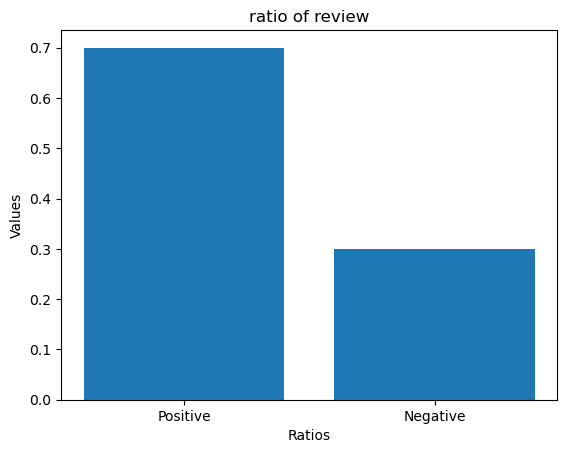

In [48]:
def draw_bar_chart(ratio1, ratio2):
    labels = ['Positive', 'Negative']
    ratios = [ratio1, ratio2]

    plt.bar(labels, ratios)
    plt.xlabel('Ratios')
    plt.ylabel('Values')
    plt.title('ratio of review')
    plt.show()

In [44]:
#naver 실시간 시연

# data/naver_data 폴더에서 리뷰 데이터 불러와서 dataframe으로 저장
test_url='./data/naver_data/sunuri_food.csv'
final_df = pd.read_csv(test_url,sep=',', header=0)
final_df.head(5)

,id,category,text,trans_text
0,0,taste,자주는 못가지만 영통갈때마다 들려요\n너무맛있음 ㅠ 주차장이 좀 더 넓으면 얼마나 좋으꼬,"I can't go often, but I hear it whenever I go ..."
1,1,taste,감자탕에 뼈 양도 많고 살코기도 많이 붙어있어요!!! 당면이랑 떡사리 등 사리 종류...,Pork back-bone soup has a lot of bones and mea...
2,2,taste,친구랑 한뚝빼기 하고 왔어요. 맛나네요^^,I played with my friend. It's delicious ^^
3,3,taste,세상에 가성비 미쳤어요ㅋㅋ학교 앞에서 성공하는데는 다 이유가 있나봐여!! 저희는 직...,The cost-effectiveness is crazyThere must be a...
4,4,taste,뼈해장국 굉장히 맛있네요!,Pork rib hangover soup is really good!


In [45]:
printLenStat(final_df,'trans_text')

count    288.000000
mean      44.364583
std       60.283960
min        9.000000
25%        9.000000
50%       21.500000
75%       47.250000
max      412.000000
Name: length, dtype: float64


In [46]:
final_text=final_df.trans_text.values
final_posResult,final_negResult=classifyReviews(final_text)

=============================== Input 1 ===============================
I can't go often, but I hear it whenever I go to the video call. It's so delicious. How nice would it be if the parking lot was wider
model result: Positive

=============================== Input 2 ===============================
Pork back-bone soup has a lot of bones and meat on it!!! There are various kinds of noodles such as glass noodles and rice cake sari. But I don't like fried rice..
model result: Negative

=============================== Input 3 ===============================
I played with my friend. It's delicious ^^
model result: Positive

=============================== Input 4 ===============================
The cost-effectiveness is crazyThere must be a reason for success in front of the school!! We had a group of office workers, and we ate a lot and drank a lot. I wondered how this was the only amount of moneyLol, the soup is so delicious and adding ramen noodles is a must. ♡ Boss, have a prosperous 

=============================== Input 62 ===============================
I went there a lot with my boyfriend when I was in college. My boyfriend becomes my husband and often goes to look back on memories. It's still delicious
model result: Positive

=============================== Input 63 ===============================
It was delicious.
model result: Positive

=============================== Input 64 ===============================
It's good
model result: Positive

=============================== Input 65 ===============================
A delicious pork back-bone stew full of flesh ♡
model result: Positive

=============================== Input 66 ===============================
It's good. It's clean and nice
model result: Positive

=============================== Input 67 ===============================
It's delicious. ^^
model result: Positive

=============================== Input 68 ===============================
It's good
model result: Positive

===============================

=============================== Input 125 ===============================
It's good
model result: Positive

=============================== Input 126 ===============================
It's good. There's a lot. The dried radish greens are good too
model result: Positive

=============================== Input 127 ===============================
It's good. It's a lot. You're kind
model result: Positive

=============================== Input 128 ===============================
The food is delicious and kind
model result: Positive

=============================== Input 129 ===============================
Thank you for the food
model result: Positive

=============================== Input 130 ===============================
The food is delicious
model result: Positive

=============================== Input 131 ===============================
It's delicious! The restaurant is spacious, so it's good for a group dinner. ^^
model result: Positive

=============================== Input 132 ========

=============================== Input 206 ===============================
It's good because it's delicious and there's a lot
model result: Positive

=============================== Input 207 ===============================
It's good
model result: Positive

=============================== Input 208 ===============================
It's good
model result: Positive

=============================== Input 209 ===============================
It's good
model result: Positive

=============================== Input 210 ===============================
It's cheap and delicious.
model result: Positive

=============================== Input 211 ===============================
It's good
model result: Positive

=============================== Input 212 ===============================
It's delicious
model result: Positive

=============================== Input 213 ===============================
It's good
model result: Positive

=============================== Input 214 ===============================


=============================== Input 274 ===============================
It's good. The restaurant in front of Kyung Hee University
model result: Positive

=============================== Input 275 ===============================
It's a lot and delicious
model result: Positive

=============================== Input 276 ===============================
The soup is amazing
model result: Positive

=============================== Input 277 ===============================
It's good
model result: Positive

=============================== Input 278 ===============================
It's good
model result: Positive

=============================== Input 279 ===============================
It's good!
model result: Positive

=============================== Input 280 ===============================
There's a table in the hall. It was nice to be able to sit comfortably.. The taste is always the best..
model result: Positive

=============================== Input 281 ===============================
I

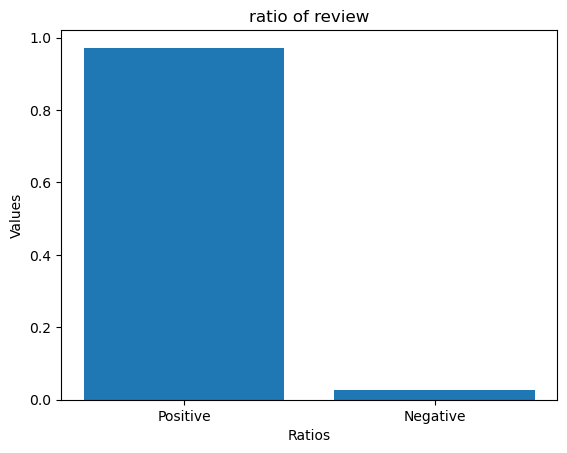

In [50]:
posRatio=len(final_posResult)/(len(final_posResult)+len(final_negResult))
negRatio=len(final_negResult)/(len(final_posResult)+len(final_negResult))
draw_bar_chart(posRatio, negRatio)

In [53]:
model.save_pretrained("./")